In [2]:
!ls

MOCK_DATA.json      backend.py          dataJul-1-2019.json model.py
Procfile            backend_algo.ipynb  firebase_test.py    requirements.txt
__pycache__         crm.py              model               venv


In [3]:
import pandas as pd 
import numpy as np
import json

from sklearn import tree
import graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.metrics import log_loss

from matplotlib import pyplot as plt

In [4]:
# Reading the json as a dict
with open('MOCK_DATA.json') as json_data:
    data = json.load(json_data)

In [5]:
bid_history = pd.DataFrame.from_dict(data)
bid_history = bid_history.set_index('id', drop=True)
def tender_acceptance_mock(row):
    if row['projected_margin'] > 0.03 and row['tender_price'] < row['budget']:
        row['tender_accepted'] = True 
    elif row['company_size']> 1 and row['projected_margin'] > 0.01:
        row['tender_accepted'] = True
    else:
        row['tender_accepted'] = False
    return row
bid_history = bid_history.apply(tender_acceptance_mock, axis=1)

In [6]:
bid_history.head(5)

,address,budget,company_name,company_size,country_code,currency,email,num_consultants,projected_costs,projected_margin,state,tender_accepted,tender_price
id,,,,,,,,,,,,,
1,44 Cherokee Drive,58789,Shufflester,3,United States,USD,alovitt0@va.gov,20,813516,0.11,North Carolina,True,405572
2,91891 Blaine Terrace,587839,Meevee,1,United States,USD,tsweetzer1@vinaora.com,2,579744,0.19,South Dakota,False,1898756
3,91758 Artisan Drive,745512,Riffpedia,2,United States,USD,cgillan2@xinhuanet.com,12,595532,0.26,Alabama,True,478080
4,537 Namekagon Plaza,660140,Topiclounge,1,United States,USD,ibarton3@businesswire.com,17,508205,0.25,Arizona,False,1031227
5,8008 Forest Circle,334807,Browsebug,1,United States,USD,rbroxton4@economist.com,1,299432,0.27,Florida,False,1607110


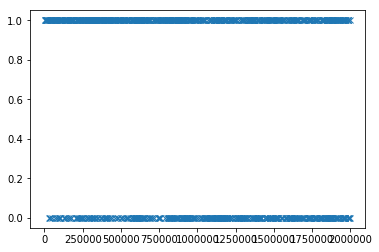

In [7]:
plt.plot( bid_history['tender_price'],bid_history['tender_accepted'], 'x')
plt.show()

In [8]:
# encode class
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(bid_history.tender_accepted)

In [9]:
# one hot country
bid_history = bid_history.join(pd.get_dummies(bid_history.country_code)).drop('country_code',axis=1)
bid_history['company_size'] = bid_history['company_size'] * 50

In [10]:
train = bid_history.drop(['tender_accepted', 'company_name','currency','state','address','email','United States'],axis=1)
Xtrain, Xvalid, ytrain, yvalid = train_test_split(train, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)
Xtrain.head()

,budget,company_size,num_consultants,projected_costs,projected_margin,tender_price
id,,,,,,
387,997338,100,13,600701,0.26,1964330
608,459562,150,5,926106,-0.05,208803
843,792696,50,16,365458,0.28,1205026
796,768301,150,6,547389,0.29,1359487
177,632803,150,3,151636,-0.02,1085710


In [11]:
print("train: ", len(Xtrain))
print("test: ", len(yvalid))

train:  800
test:  200


In [12]:
clf = LogisticRegression(C=1.0)
clf.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
predictions = clf.predict_proba(Xvalid)


In [14]:
log_loss(yvalid,predictions)

0.5197448343138538

In [15]:
tr = tree.DecisionTreeClassifier()
tr.fit(Xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
predictions = tr.predict_proba(Xvalid)
log_loss(yvalid,predictions)

0.3453877639491077

In [17]:
print(Xtrain.iloc[0])

budget               997338.00
company_size            100.00
num_consultants          13.00
projected_costs      600701.00
projected_margin          0.26
tender_price        1964330.00
Name: 387, dtype: float64


In [18]:
test_val = []
for x in np.linspace(-0.05, 0.2, 26):
    test_val.append(Xtrain.iloc[0])
    
for t,v in zip(test_val,np.linspace(-0.05, 0.2, 26)):
    t.projected_margin = v

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [19]:
pred_clf = clf.predict_proba(test_val)
pred_tree = tr.predict_proba(test_val)

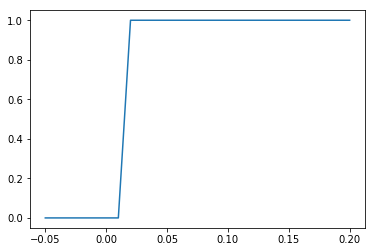

In [20]:
plt.plot(np.linspace(-0.05, 0.2, 26),pred_tree[:,1])
#plt.plot(np.linspace(-0.05, 0.2, 26),pred_clf[:,1])
plt.show()

In [21]:
# # Imports the Google Cloud client library
# from google.cloud import storage

# # Instantiates a client
# storage_client = storage.Client()

# # The name for the new bucket
# bucket_name = 'my-new-bucket'

# # Creates the new bucket
# bucket = storage_client.create_bucket(bucket_name)

# print('Bucket {} created.'.format(bucket.name))

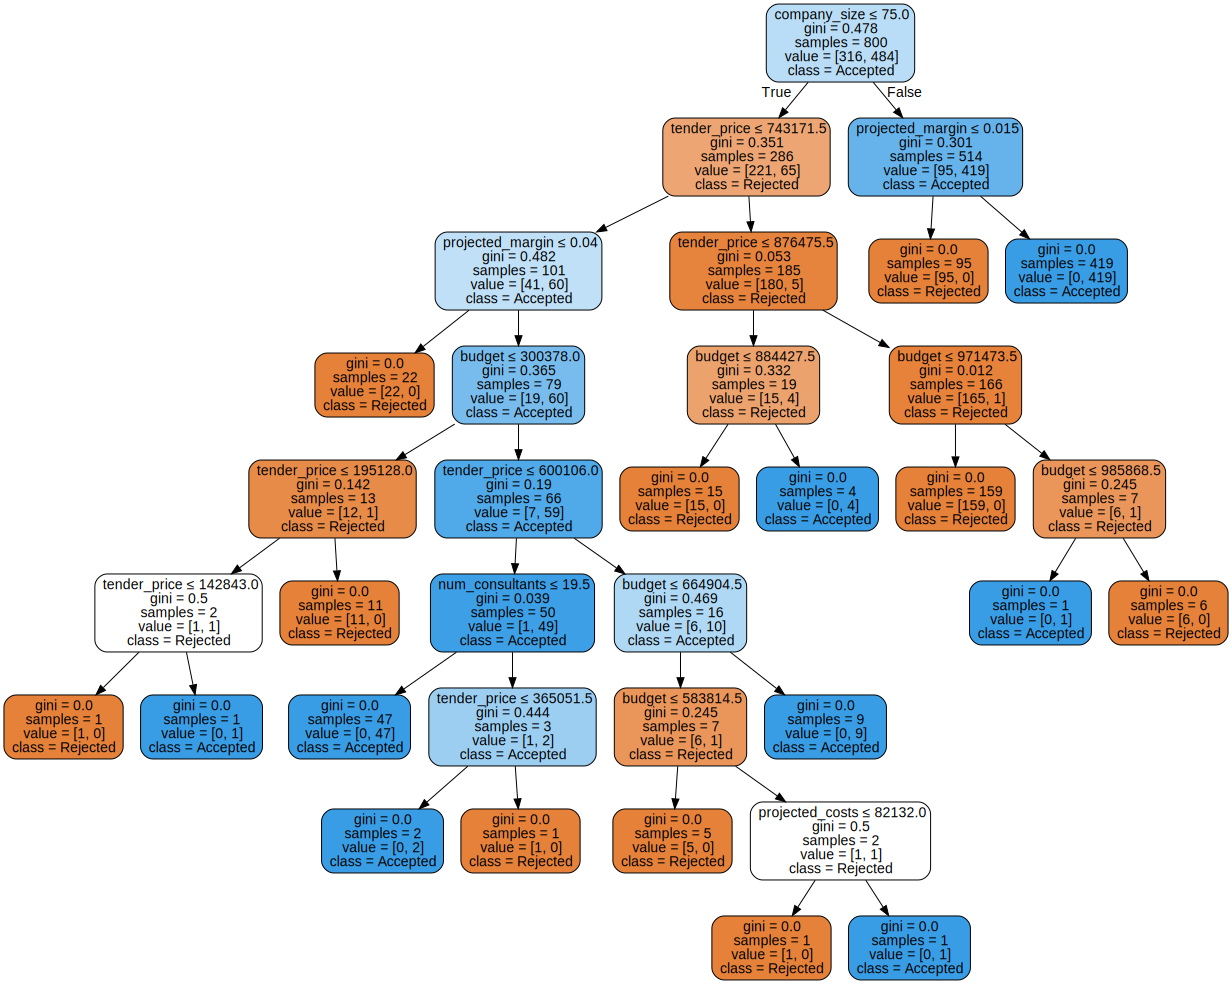

In [22]:
dot_data = tree.export_graphviz(tr, out_file=None,
                         feature_names=['budget','company_size','num_consultants','projected_costs','projected_margin','tender_price'],  
                         class_names=['Rejected','Accepted'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [26]:
from joblib import dump, load
dump(tr, 'model')

['model']

In [27]:
model = load('model')

In [28]:
model.predict_proba([[123123,100,1231,123213,0.3,123]])

array([[0., 1.]])